In [1]:
from src.data.load_data import *
from src.models.util_model import *
from src.data.preprocess import *
from src.data.postprocess import *
from src.data.util import *
from pathlib import Path

In [2]:
dataset_path = Path("data/raw")
image_path = dataset_path / "trans021-1.png"
image = read_image(image_path)

In [3]:
section_dict = detect_section(image)


0: 640x480 3 sections, 895.8ms
Speed: 2.8ms preprocess, 895.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


In [4]:
processed_sections = preprocess(section_dict)

In [5]:
ocr_results = OCR(processed_sections)

In [6]:
courses_df = make_course(ocr_results)

#section0
ocr: shape(s) = 36
numeric: shape(s) = 36
section: shape(s) = 36
id: shape(s) = 36
name: shape(s) = 36
unit: shape(s) = 36
grade: shape(s) = 36
weight: shape(s) = 36
#section1
ocr: shape(s) = 40
numeric: shape(s) = 40
section: shape(s) = 40
id: shape(s) = 40
name: shape(s) = 40
unit: shape(s) = 40
grade: shape(s) = 40
weight: shape(s) = 40
#section2
ocr: shape(s) = 43
numeric: shape(s) = 43
section: shape(s) = 43
id: shape(s) = 43
name: shape(s) = 43
unit: shape(s) = 43
grade: shape(s) = 43
weight: shape(s) = 43


In [7]:
courses_df

,ocr,numeric,section,id,name,unit,grade,weight
0,ค33101: คณิตศาสตร์ 5 10 4,1 4,000,ค33101,คณิตศาสตร์ 5,1.0,4.0,"[1.0, 4.0]"
1,ว30105: วิทยาศาสตร์ 5 10 4,1 4,001,ว30105,วิทยาศาสตร์ 5,1.0,4.0,"[1.0, 4.0]"
2,ส33101: สังคมศึกษา ศาสนาและวัฒนธรรม 5 ...,1 4,002,ส33101,สังคมศึกษา,1.0,4.0,"[1.0, 4.0]"
3,พ33101: สุขศึกษาและพลศึกษา 5 05 4,5 4,003,พ33101,สุขศึกษาและพลศึกษา 5,0.5,4.0,"[0.5, 4.0]"
4,33101: ศิลปะ 5 05 4,5 4,004,999,ศิลปะ 5,0.5,4.0,"[0.5, 4.0]"
...,...,...,...,...,...,...,...,...
114,ว30268: โครงงาน 1 10 | 4,1 4,238,ว30268,โครงงาน 1,1.0,4.0,"[1.0, 4.0]"
115,ว30290: เทคนิคปฏิบัติการพื้นฐานทางวิทยาศาสตร์ ...,1 1 4,239,ว30290,เทคนิคปฏิบัติการพื้นฐานทางวิทยาศาสตร์ 1,999.0,999.0,"[999, 999]"
116,ว30291: เทคนิคปฏิบัติการพื้นฐานทางวิทยาศาสตร์ ...,2 1 4,240,ว30291,เทคนิคปฏิบัติการพื้นฐานทางวิทยาศาสตร์ 2,999.0,999.0,"[999, 999]"
117,อ30204: การเขียนรายงานการวิจัยภาษาอังกฤษ ...,1 4,241,อ30204,การเขียนรายงานการวิจัยภาษาอังกฤษ,1.0,4.0,"[1.0, 4.0]"


In [8]:
courses_df.loc[courses_df['section'].str.startswith('2')].shape

(43, 8)

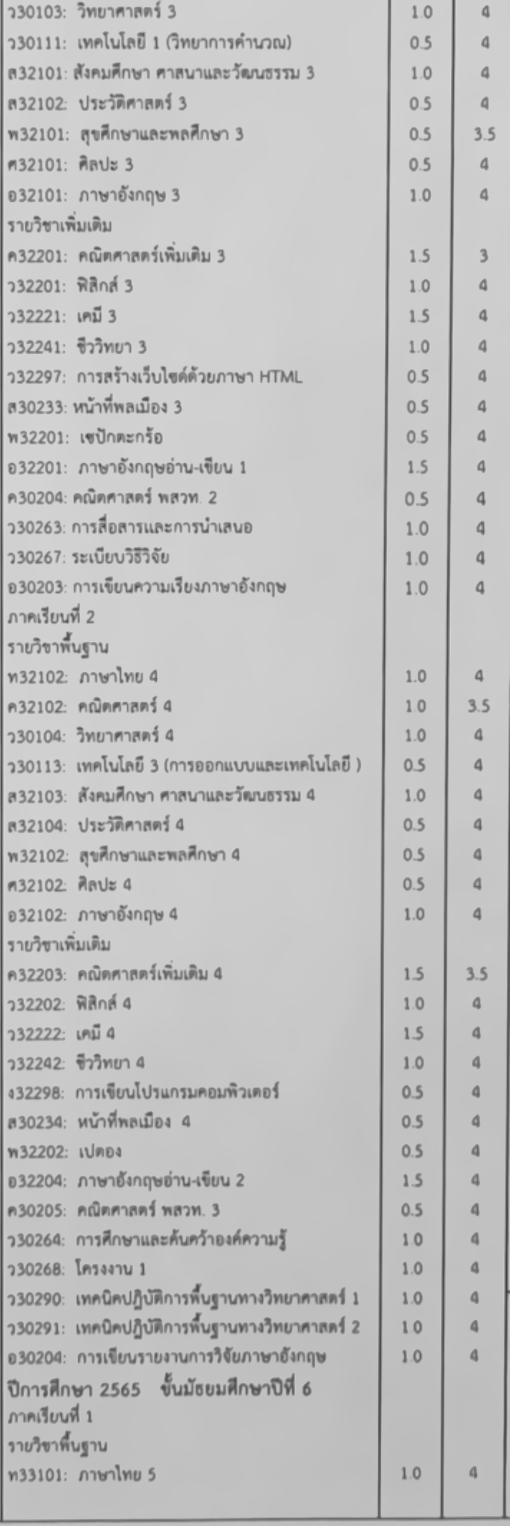

In [9]:
section_dict[2]